# AutoEncoder para Detección de Anomalías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Datos

In [29]:
# datos sintéticos
data, _ = make_blobs(n_samples=1000, centers=[[0, 0]], cluster_std=0.4, random_state=42)

# datos en entrenamiento y prueba
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# anomalías sintéticas
np.random.seed(42)
n_anomalies = 50
anomalies = np.random.uniform(low=-6, high=6, size=(n_anomalies, 2))
X_test_anomaly = np.vstack([X_test, anomalies])

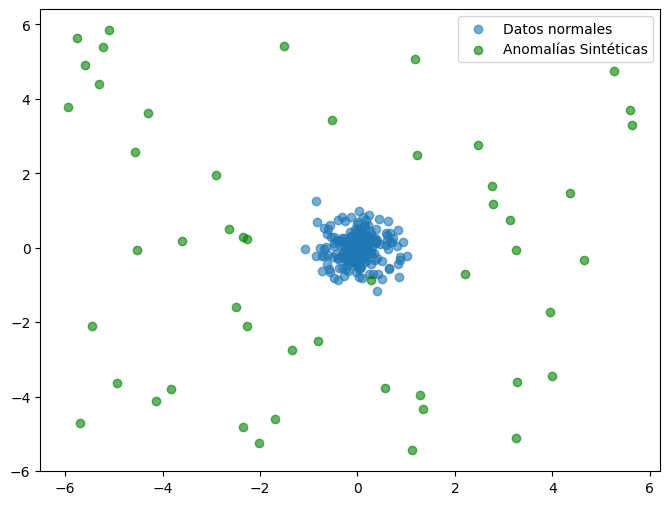

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], label='Datos normales', alpha=0.6)
plt.scatter(anomalies[:, 0], anomalies[:, 1], label='Anomalías Sintéticas', alpha=0.6, color='green')
plt.legend()
plt.show()

## AutoEncoder
### Arquitectura

In [31]:
# arquitectura del autoencoder
input_dim = X_train.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoder = Dense(10, activation="relu")(input_layer)
encoder = Dense(encoding_dim, activation="relu")(encoder)
decoder = Dense(10, activation='relu')(encoder)
decoder = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [32]:
# from tensorflow.keras.utils import plot_model

# # Visualizamos arquitectura del autoencoder
# plot_model(autoencoder, to_file='autoencoder_architecture.png', show_shapes=True, show_layer_names=True)

### Entrenamiento

In [33]:
# entrenamiento
# detiene automáticamente el entrenamiento cuando esta métrica deja de mejorar después de un número determinado de epochs.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(X_train, X_train, epochs=200, batch_size=32, validation_data=(X_test, X_test),callbacks=[early_stopping])

Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1829 - val_loss: 0.1603
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1535 - val_loss: 0.1447
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1319 - val_loss: 0.1300
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1295 - val_loss: 0.1153
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1062 - val_loss: 0.1016
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0888 - val_loss: 0.0910
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0891 - val_loss: 0.0843
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0814 - val_loss: 0.0801
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0784 - val_loss: 0.0774
Epoch 10/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0762 - val_loss: 0.0740
Epoch 11/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0714 - val_loss: 0.0682
Epoch 12/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss

In [34]:
# predicción
reconstruction = autoencoder.predict(X_test_anomaly)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [35]:
# calcular el error
reconstruction_error = np.mean(np.square(X_test_anomaly - reconstruction), axis=1)
# threshold como percentil 95 del error en datos normales
threshold = np.percentile(reconstruction_error[:-n_anomalies], 95)

In [36]:
threshold

np.float64(6.207722512262896e-07)

In [37]:
# Identificar anomalías
anomaly_flags = reconstruction_error > threshold
anomaly_flags

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

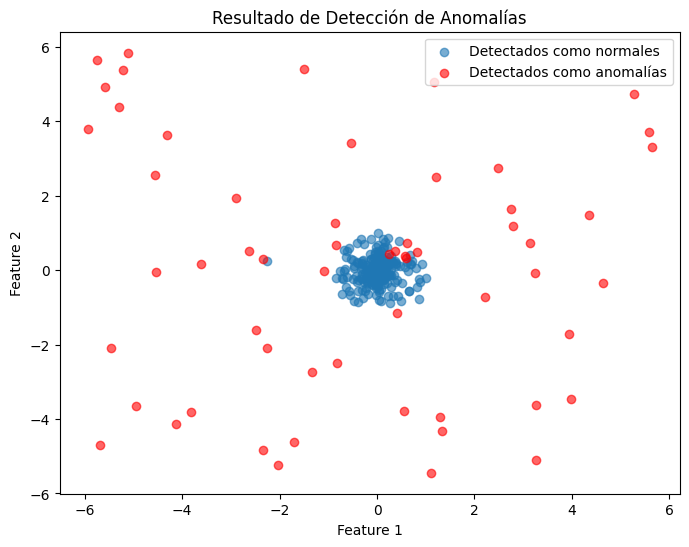

In [38]:
# Visualizar detección de anomalías
plt.figure(figsize=(8, 6))
plt.scatter(X_test_anomaly[~anomaly_flags, 0], X_test_anomaly[~anomaly_flags, 1], label='Detectados como normales', alpha=0.6)
plt.scatter(X_test_anomaly[anomaly_flags, 0], X_test_anomaly[anomaly_flags, 1], label='Detectados como anomalías', alpha=0.6, color='red')
plt.legend()
plt.title('Resultado de Detección de Anomalías')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

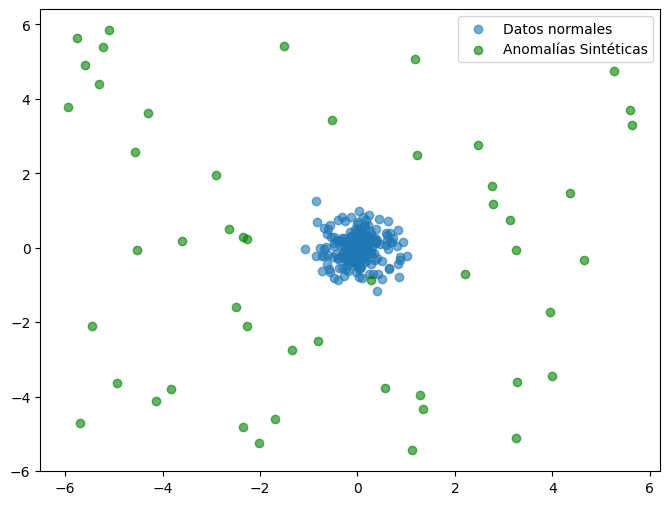

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], label='Datos normales', alpha=0.6)
plt.scatter(anomalies[:, 0], anomalies[:, 1], label='Anomalías Sintéticas', alpha=0.6, color='green')
plt.legend()
plt.show()